## Clasificador Bayesiano

Vamos a comparar contra un clasificador bayesiano para poder ver si lo mejoramos o no.



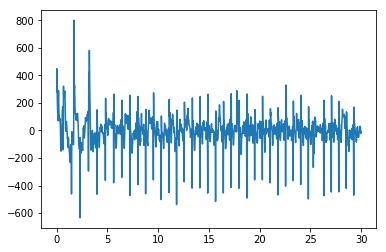

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
#load data
import numpy as np

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

fs = 300. 
t = np.arange(len(X_train[0]))/fs
plt.plot(t,X_train[0,:])

#Es probable que tengamos un problema mal condicionado: vamos a realizar un submuestreo de la señal a 50 muestras por segundo
from scipy import signal

decimate = False

if decimate:
    freq = fs/10#Hz
    print(freq)
    secs = len(X_train[200])/fs
    samps = int(secs*freq)
    c = 0
    X_new = np.zeros((X_train.shape[0],samps))
    X_new_test = np.zeros((X_test.shape[0],samps))
    for x,x_test in zip(X_train,X_test):
        X_new[c,:] = signal.decimate(x,10)
        X_new_test[c,:] = signal.decimate(x_test,10)
    
        c += 1
    
    t = np.arange(len(X_new[200]))/freq
    plt.plot(t,X_new[200,:])
    print(len(X_new[0]))

    X_train = X_new.copy()
    X_test = X_new_test.copy()

## Vamos a probar dos modelos:
** 1.- Sin utilizar normalización y centrado de los datos **

** 2.- Normalizando y centrando los datos **


### 1 Modelo sin normalización

In [23]:
#1 Sin normalizar

from sklearn.naive_bayes import GaussianNB
from time import time

from sklearn import metrics
#creamos el modelo
clf = GaussianNB()


#entrenamos el modelo
t0 = time()
clf.fit(X_train,y_train)
train_time = time() - t0
print("El tiempo de entrenamiento ha sido: %.2f"%(train_time))

El tiempo de entrenamiento ha sido: 0.61


In [24]:
#Predecimos con el modelo
t0 = time()
y_hat = clf.predict(X_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

#obtenemos el conjunto de metricas 
target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat)
print("accuracy:   %0.3f" % score)

#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat,target_names=target_names))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_hat))

#parece que simplemente elige una de las soluciones,debe ser por el problema del balanceado
from collections import Counter

#vamos a ver el número de elementos diferentes en y_test y en y_hat

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_test")
print(sorted(Counter(y_test).items()))

print("y_hat")
print(sorted(Counter(y_hat).items()))


test time:  0.351s
accuracy:   0.207
classification report:
             precision    recall  f1-score   support

     Normal       0.66      0.16      0.26       736
         AF       0.10      0.72      0.17       100
      Other       0.31      0.15      0.20       335
      Noise       0.09      0.40      0.14        25

avg / total       0.51      0.21      0.23      1196

confusion matrix:
[[117 463  92  64]
 [  9  72  13   6]
 [ 46 207  49  33]
 [  4   6   5  10]]
"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_test
[(0, 736), (1, 100), (2, 335), (3, 25)]
y_hat
[(0, 176), (1, 748), (2, 159), (3, 113)]


In [25]:
#Vamos a probar balanceando con under sampling y over sampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_resampled")
print(sorted(Counter(y_resampled).items()))

print("y_oversampled")
print(sorted(Counter(y_oversampled).items()))


print("y_train")
print(sorted(Counter(y_train).items()))

"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_resampled
[(0, 100), (1, 100), (2, 100), (3, 100)]
y_oversampled
[(0, 2942), (1, 2942), (2, 2942), (3, 2942)]
y_train
[(0, 2942), (1, 399), (2, 1340), (3, 100)]


## Resultados under sampling

accuracy:   0.273
classification report:
             precision    recall  f1-score   support

     Normal       0.71      0.14      0.24       736
         AF       0.08      0.17      0.11       100
      Other       0.29      0.58      0.39       335
      Noise       0.07      0.48      0.13        25

avg / total       0.53      0.27      0.27      1196

Confusion matrix, without normalization
[[104 139 400  93]
 [ 12  17  62   9]
 [ 28  61 194  52]
 [  3   2   8  12]]
Normalized confusion matrix
[[0.14 0.19 0.54 0.13]
 [0.12 0.17 0.62 0.09]
 [0.08 0.18 0.58 0.16]
 [0.12 0.08 0.32 0.48]]


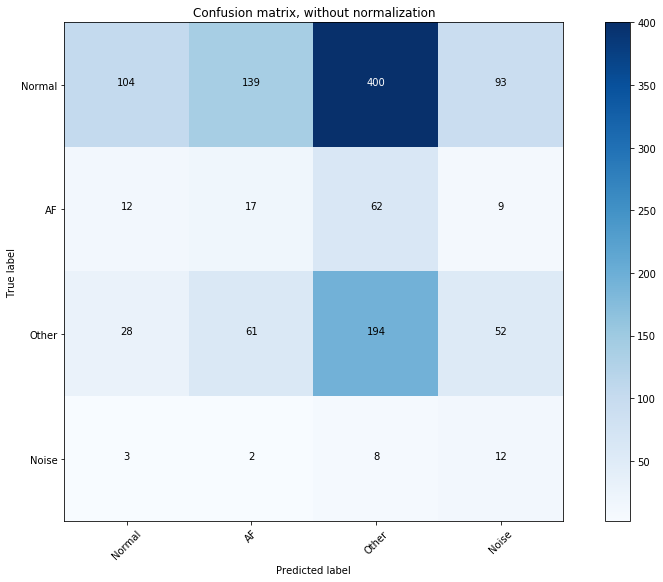

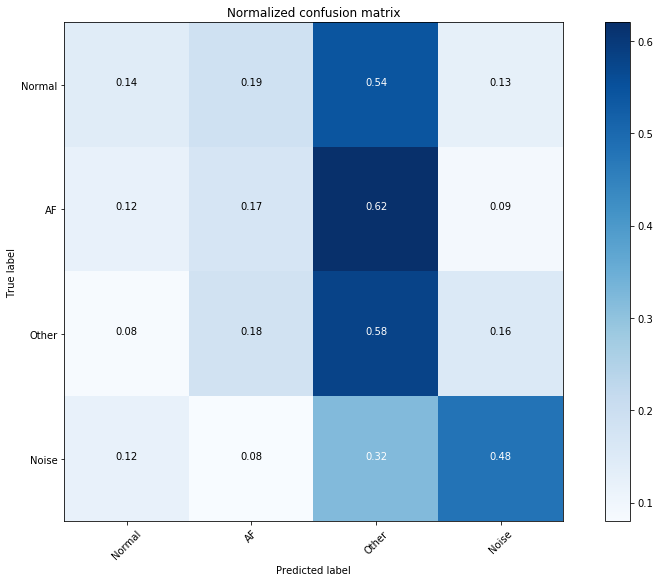

In [26]:
%matplotlib inline
#Resultados under sampling

clf_under = GaussianNB()

clf_under.fit(X_resampled,y_resampled)

y_hat_under = clf_under.predict(X_test)


target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_under)
print("accuracy:   %0.3f" % score)

#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_under,target_names=target_names))

from tfg_tools import *

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_under)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')
plt.figure(figsize = (12,8))
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')


## Resultados Over sampling

accuracy:   0.207
classification report:
             precision    recall  f1-score   support

     Normal       0.64      0.18      0.28       736
         AF       0.09      0.67      0.16       100
      Other       0.26      0.11      0.16       335
      Noise       0.09      0.40      0.14        25

avg / total       0.47      0.21      0.23      1196

Confusion matrix, without normalization
[[132 445  93  66]
 [ 13  67  14   6]
 [ 58 204  38  35]
 [  4   8   3  10]]
Normalized confusion matrix
[[0.18 0.6  0.13 0.09]
 [0.13 0.67 0.14 0.06]
 [0.17 0.61 0.11 0.1 ]
 [0.16 0.32 0.12 0.4 ]]


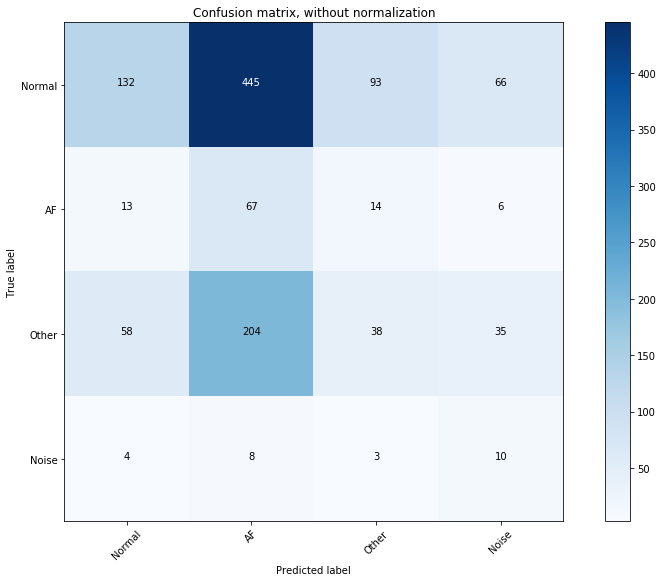

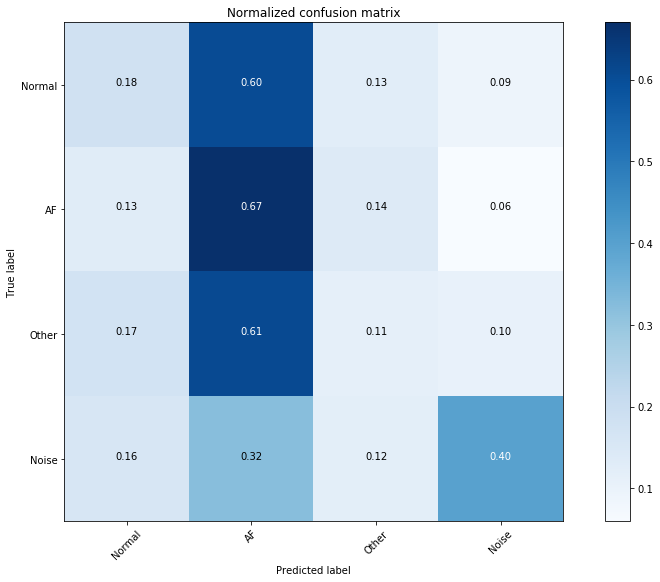

In [27]:
%matplotlib inline
#Resultados over sampling

clf_over = GaussianNB()

clf_over.fit(X_oversampled,y_oversampled)

y_hat_over = clf_over.predict(X_test)


target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_over)
print("accuracy:   %0.3f" % score)

#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_over,target_names=target_names))

from tfg_tools import *

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_over)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')
plt.figure(figsize = (12,8))
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

### 2. Modelo Normalizando

In [28]:
from sklearn.preprocessing import StandardScaler

#normalizamos train
my_scaler = StandardScaler()

X_train_n = my_scaler.fit_transform(X_train)
#entrenamos el modelo
t0 = time()
clf.fit(X_train_n,y_train)
train_time = time() - t0
print("El tiempo de entrenamiento ha sido: %.2f"%(train_time))

/home/miguelangel/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


El tiempo de entrenamiento ha sido: 0.69


test time:  0.358s
accuracy:   0.207
classification report:
             precision    recall  f1-score   support

     Normal       0.66      0.16      0.26       736
         AF       0.10      0.72      0.17       100
      Other       0.31      0.15      0.20       335
      Noise       0.09      0.40      0.14        25

avg / total       0.51      0.21      0.23      1196

confusion matrix:
Confusion matrix, without normalization
[[117 463  92  64]
 [  9  72  13   6]
 [ 46 207  49  33]
 [  4   6   5  10]]
"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_test
[(0, 736), (1, 100), (2, 335), (3, 25)]
y_hat
[(0, 176), (1, 748), (2, 159), (3, 113)]


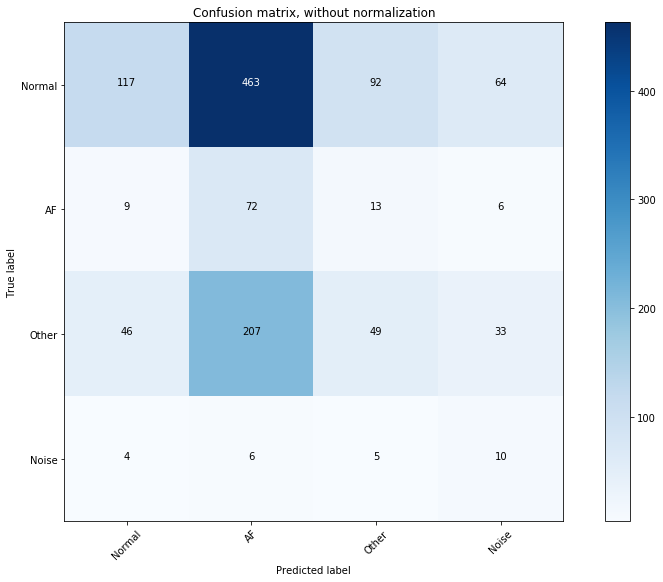

In [29]:
#Predecimos con el modelo

X_test_n = my_scaler.transform(X_test)

t0 = time()
y_hat_n = clf.predict(X_test_n)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

#obtenemos el conjunto de metricas 

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_n)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_n,target_names=target_names))


print("confusion matrix:")
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_n)
# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

#parece que simplemente elige una de las soluciones,debe ser por el problema del balanceado
from collections import Counter

#vamos a ver el número de elementos diferentes en y_test y en y_hat


print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_test")
print(sorted(Counter(y_test).items()))

print("y_hat")
print(sorted(Counter(y_hat_n).items()))


In [30]:
#Undersmapling y oversampling con normalización

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X_train_n, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train_n, y_train)

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_resampled")
print(sorted(Counter(y_resampled).items()))

print("y_oversampled")
print(sorted(Counter(y_oversampled).items()))


print("y_train")
print(sorted(Counter(y_train).items()))

"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_resampled
[(0, 100), (1, 100), (2, 100), (3, 100)]
y_oversampled
[(0, 2942), (1, 2942), (2, 2942), (3, 2942)]
y_train
[(0, 2942), (1, 399), (2, 1340), (3, 100)]


accuracy:   0.273
classification report:
             precision    recall  f1-score   support

     Normal       0.71      0.14      0.24       736
         AF       0.08      0.17      0.11       100
      Other       0.29      0.58      0.39       335
      Noise       0.07      0.48      0.13        25

avg / total       0.53      0.27      0.27      1196

Confusion matrix, without normalization
[[104 139 400  93]
 [ 12  17  62   9]
 [ 28  61 194  52]
 [  3   2   8  12]]


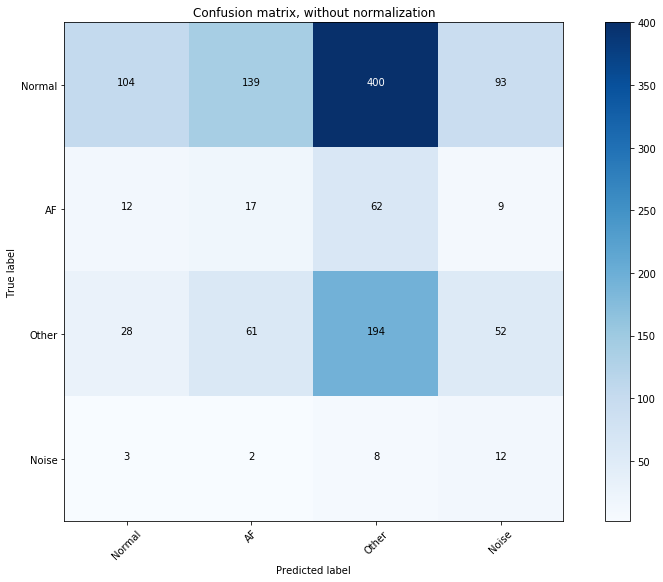

In [31]:
#undersampling con normalización de los datos

clf_under = GaussianNB()

clf_under.fit(X_resampled,y_resampled)


y_hat_under = clf_under.predict(X_test_n)


target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_under)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_under,target_names=target_names))

from tfg_tools import *

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_under)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

## Regresión Logística

En último lugar vamos a utilizar regresión logística.



accuracy:   0.253
classification report:
             precision    recall  f1-score   support

     Normal       0.58      0.26      0.36       736
         AF       0.09      0.22      0.13       100
      Other       0.25      0.25      0.25       335
      Noise       0.01      0.12      0.02        25

avg / total       0.43      0.25      0.30      1196

Confusion matrix, without normalization
[[193 156 207 180]
 [ 25  22  36  17]
 [108  55  84  88]
 [  7   7   8   3]]


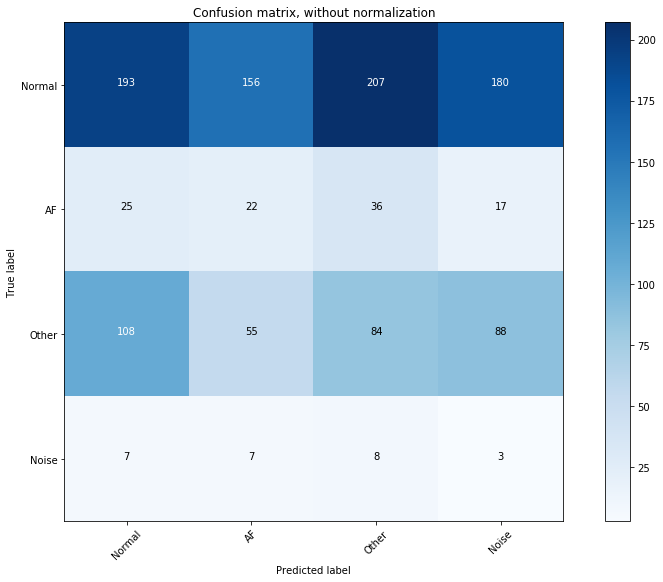

In [32]:
#Regresión logística multinomial

from sklearn.linear_model import LogisticRegression

lr_under = LogisticRegression(multi_class= 'multinomial',solver = 'lbfgs')

#Vamos a utilizar undersampling y oversampling normalizado

lr_under.fit(X_resampled,y_resampled)

y_hat_under = lr_under.predict(X_test_n)

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_under)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_under,target_names=target_names))

from tfg_tools import *

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_under)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

accuracy:   0.391
classification report:
             precision    recall  f1-score   support

     Normal       0.63      0.49      0.55       736
         AF       0.09      0.18      0.12       100
      Other       0.27      0.27      0.27       335
      Noise       0.03      0.12      0.05        25

avg / total       0.47      0.39      0.42      1196

Confusion matrix, without normalization
[[357 118 212  49]
 [ 43  18  31   8]
 [157  52  90  36]
 [ 10   6   6   3]]


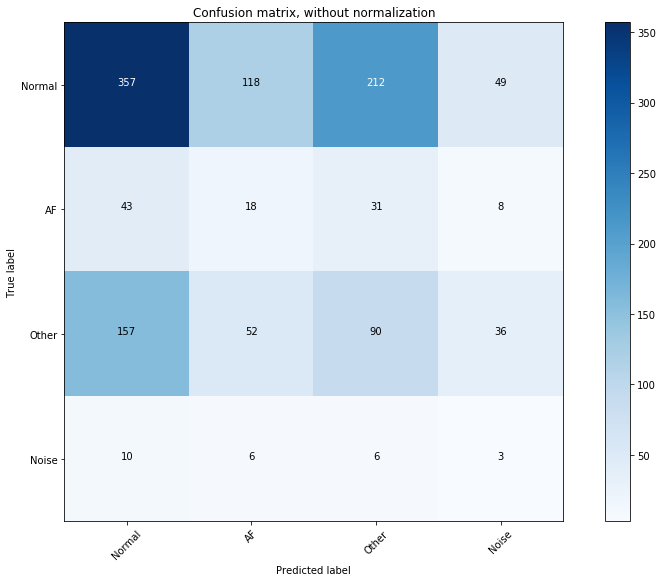

In [33]:

lr_over = LogisticRegression(multi_class= 'multinomial',solver = 'lbfgs')

#Vamos a utilizar undersampling y oversampling normalizado

lr_over.fit(X_oversampled,y_oversampled)

y_hat_over = lr_over.predict(X_test_n)

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_over)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_over,target_names=target_names))

from tfg_tools import *

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_over)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')